In [1]:
#현재 위치 확인
!pwd

/content


In [2]:
#ACGPN 모델 파일 다운로드
!git clone https://github.com/kairess/ACGPN.git

Cloning into 'ACGPN'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 165 (delta 21), reused 19 (delta 18), pack-reused 141
Receiving objects: 100% (165/165), 303.15 KiB | 9.78 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [3]:
#다운로드 받은 파일의 위치로 이동
%cd ACGPN

/content/ACGPN


# dependencies 및 사전 파일 준비

In [4]:
!pip install -U --no-cache-dir gdown --pre -qq
!pip install ninja -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 5.1 MB/s eta 0:00:00


In [5]:
import gdown
import numpy as np
from PIL import Image
import IPython
import os
import sys
import time

from predict_pose import generate_pose_keypoints

In [6]:
#모델을 돌리기 위한 파일 준비
!mkdir Data_preprocessing/test_color
!mkdir Data_preprocessing/test_colormask
!mkdir Data_preprocessing/test_edge
!mkdir Data_preprocessing/test_img
!mkdir Data_preprocessing/test_label
!mkdir Data_preprocessing/test_mask
!mkdir Data_preprocessing/test_pose
!mkdir inputs
!mkdir inputs/img
!mkdir inputs/cloth

In [7]:
#현재 위치 확인
!pwd

/content/ACGPN


In [8]:
#휴먼 세그멘테이션 모델 파일 다운로드
!git clone https://github.com/levindabhi/Self-Correction-Human-Parsing-for-ACGPN.git
#옷 마스킹 모델 파일 다운로드
!git clone https://github.com/levindabhi/U-2-Net.git

Cloning into 'Self-Correction-Human-Parsing-for-ACGPN'...
remote: Enumerating objects: 769, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 769 (delta 72), reused 62 (delta 62), pack-reused 658
Receiving objects: 100% (769/769), 3.80 MiB | 19.74 MiB/s, done.
Resolving deltas: 100% (189/189), done.
Cloning into 'U-2-Net'...
remote: Enumerating objects: 822, done.
remote: Total 822 (delta 0), reused 0 (delta 0), pack-reused 822
Receiving objects: 100% (822/822), 30.72 MiB | 32.73 MiB/s, done.
Resolving deltas: 100% (379/379), done.


# 사전학습된 모델 다운로드

# 포즈 예측 모델

In [9]:
!gdown 1hOHMFHEjhoJuLEQY0Ndurn5hfiA9mwko -O pose/pose_iter_440000.caffemodel

Downloading...
From (uriginal): https://drive.google.com/uc?id=1hOHMFHEjhoJuLEQY0Ndurn5hfiA9mwko
From (redirected): https://drive.google.com/uc?id=1hOHMFHEjhoJuLEQY0Ndurn5hfiA9mwko&confirm=t&uuid=ed5117c2-6132-40de-ab39-7f62ee10eb62
To: /content/ACGPN/pose/pose_iter_440000.caffemodel
100% 209M/209M [00:05<00:00, 38.0MB/s]


# 휴먼 세그멘테이션 모델

In [10]:
gdown.download('https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH', 'lip_final.pth', quiet=False)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH
From (redirected): https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH&confirm=t&uuid=724e4d43-d5fa-4b4d-b17c-548876d4d8dc
To: /content/ACGPN/lip_final.pth
100%|██████████| 267M/267M [00:09<00:00, 29.1MB/s]


'lip_final.pth'

# U-2-Net 모델 (옷 마스크 추출 모델)

In [11]:
#U-2-Net 모델을 돌릴 때 필요한 파일 준비를 위해 해당 모델 파일로 이동
%cd U-2-Net

#U-2-Net 모델에 필요한 파일 생성
!mkdir saved_models
!mkdir saved_models/u2net
!mkdir saved_models/u2netp

#사전 학습된 U-2-Net 모델 다운로드
!gdown 1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy -O saved_models/u2netp/u2netp.pth
!gdown 1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ -O saved_models/u2net/u2net.pth

import u2net_load
import u2net_run

#로드하려면 쿠다 필요 (위치 확인용)
u2net = u2net_load.model(model_name='u2netp')

#U-2-Net 모델을 위한 파일 준비가 끝나면 부모 파일로 이동
%cd ..

/content/ACGPN/U-2-Net
mkdir: cannot create directory ‘saved_models’: File exists
Downloading...
From: https://drive.google.com/uc?id=1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy
To: /content/ACGPN/U-2-Net/saved_models/u2netp/u2netp.pth
100% 4.68M/4.68M [00:00<00:00, 71.9MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ
From (redirected): https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ&confirm=t&uuid=e321e496-879f-463a-ac4e-b51ffb6040fc
To: /content/ACGPN/U-2-Net/saved_models/u2net/u2net.pth
100% 176M/176M [00:03<00:00, 52.2MB/s]
...load U2NEP---4.7 MB
/content/ACGPN


# ACGPN 모델 (사진 합성 모델)

In [12]:
#ACGPN 모델에 필요한 파일 생성
!mkdir checkpoints

#사전 학습된 ACGPN 모델 다운로드
gdown.download('https://drive.google.com/uc?id=1UWT6esQIU_d4tUm8cjxDKMhB8joQbrFx', output='checkpoints/ACGPN_checkpoints.zip', quiet=False)

#압축된 모델 파일 풀어서 전에 만든 파일위치에 넣어줌
!unzip checkpoints/ACGPN_checkpoints.zip -d checkpoints

Downloading...
From (uriginal): https://drive.google.com/uc?id=1UWT6esQIU_d4tUm8cjxDKMhB8joQbrFx
From (redirected): https://drive.google.com/uc?id=1UWT6esQIU_d4tUm8cjxDKMhB8joQbrFx&confirm=t&uuid=c3067566-ef2e-45a0-b3fb-67f7bbaca619
To: /content/ACGPN/checkpoints/ACGPN_checkpoints.zip
100%|██████████| 524M/524M [00:02<00:00, 201MB/s]


Archive:  checkpoints/ACGPN_checkpoints.zip
   creating: checkpoints/label2city/
  inflating: checkpoints/label2city/latest_net_G.pth  
  inflating: checkpoints/label2city/latest_net_G1.pth  
  inflating: checkpoints/label2city/latest_net_G2.pth  
  inflating: checkpoints/label2city/latest_net_U.pth  
  inflating: checkpoints/label2city/opt.txt  



# ✅ 여기까지 성공했으면 사전에 준비해야할 모델과 파일은 끝

이제 데이터셋을 준비하자

1. VITON 데이터셋
https://drive.google.com/uc?id=1tE7hcVFm8Td8kRh5iYRBSDFdvZIkbUIR

(ACGPN모델이 VITON 데이터셋으로 학습돼있다 - 테스트용)

2. AI허브 패션 데이터셋
https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=78

(나중에 추가학습이 가능하다면 사용할 데이터셋)

# 전처리

# 옷 마스크 추출

In [15]:
#옷 데이터셋이 올바른 위치에 있는지 확인
sorted(os.listdir('inputs/cloth'))

['000048_1.jpg']

Generating mask for: cloth_1681312173.png
Saving output at Data_preprocessing/test_edge/cloth_1681312173.png


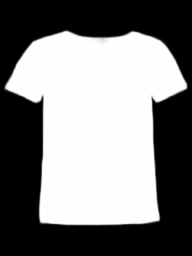

In [16]:
#전처리 할 옷 데이터 이름을 시간으로 지정
cloth_name = f'cloth_{int(time.time())}.png'

#전처리 할 옷 데이터의 파일 위치 확인
cloth_path = os.path.join('inputs/cloth', sorted(os.listdir('inputs/cloth'))[0])

#gpt한테 물어보기
cloth = Image.open(cloth_path)

#gpt한테 물어보기 - 아마 사이즈 조절
cloth = cloth.resize((192, 256), Image.BICUBIC).convert('RGB')

#전처리를 위해 옷 이미지 파일을 해당 파일 위치에 지정해준 옷 데이터 이름으로 저장
cloth.save(os.path.join('Data_preprocessing/test_color', cloth_name))

#전처리를 위해 U-2-Net모델을 지정한 파일 위치에서 데이터셋을 가저와서 돌리고, 지정한 위치에 전처리 된 옷 이미지 파일을 저장
u2net_run.infer(u2net, 'Data_preprocessing/test_color', 'Data_preprocessing/test_edge')

#결과 확인을 위해 전처리 된 옷 이미지 파일을 열어봄
Image.open(f'Data_preprocessing/test_edge/{cloth_name}')

# 모델 세그멘테이션 및 마스크 추출

In [17]:
#모델 데이터셋이 올바른 위치에 있는지 확인
sorted(os.listdir('inputs/img'))

['000028_0.jpg']

In [18]:
#전처리 할 모델 데이터 이름을 시간으로 지정
img_name = f'img_{int(time.time())}.png'

#전처리 할 모델 데이터의 파일 위치 확인
img_path = os.path.join('inputs/img', sorted(os.listdir('inputs/img'))[0])

#gpt한테 물어보기 
img = Image.open(img_path)

#gpt한테 물어보기 - 아마 사이즈 조절
img = img.resize((192,256), Image.BICUBIC)

#전처리를 위해 모델 이미지 파일의 위치값을 해당 파일 위치에 지정해준 모델 데이터 이름으로 지정
img_path = os.path.join('Data_preprocessing/test_img', img_name)

#지정해준 모델 이미지 파일의 위치값을 바탕으로 이미지 저장
img.save(img_path)

#전처리를 위해 휴먼 세그멘테이션 모델을 parser를 이용하여 돌림 ***parser는 데이터셋의 종류, 사전학습 모델 파일의 위치, 전처리 할 모델 이미지 위치, 전처리 후 이미지 저장할 위치
!python3 Self-Correction-Human-Parsing-for-ACGPN/simple_extractor.py --dataset 'lip' --model-restore 'lip_final.pth' --input-dir 'Data_preprocessing/test_img' --output-dir 'Data_preprocessing/test_label'

#모델 포즈 예측 모델을 돌리고 저장할 파일 위치와 파일 이름 형식을 지정
pose_path = os.path.join('Data_preprocessing/test_pose', img_name.replace('.png', '_keypoints.json'))

#모델 포즈 예측 모델을 전처리 할 모델 이미지 위치, 전처리 후 파일 위치를 받아서 돌리고 저장
generate_pose_keypoints(img_path, pose_path)

100% 1/1 [00:00<00:00,  1.83it/s]
File saved at Data_preprocessing/test_pose/img_1681312188_keypoints.json


# ✅ 전처리 checkpoint
Data_preprocessing/test_color >> 옷 이미지

Data_preprocessing/test_img   >> 모델 이미지

Data_preprocessing/test_edge  >> 옷 마스크 이미지

Data_preprocessing/test_label  >> 모델 세그멘테이션 마스크 이미지

Data_preprocessing/test_pose >> 모델 세그멘테이션 json파일

위의 경로에 제대로 파일들이 존재한다면 전처리는 끝

# 추론

In [19]:
#기존에 존재하던 test_pairs.txt파일을 삭제 후 이번에 돌릴 이미지 이름들로 고쳐서 생성 *** 기존 test_pairs.txt파일에는 input으로 넣어준 옷 이미지 모델 이름과, 모델 이미지 이름이 존재
!rm -rf Data_preprocessing/test_pairs.txt
with open('Data_preprocessing/test_pairs.txt', 'w') as f:
    f.write(f'{img_name} {cloth_name}')

In [20]:
#ACGPN 추론 실행
!python test.py

?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global
ngf: 64
niter_fix_global: 0
no_flip: False
norm: instance
ntest: inf
onnx: None
output_nc: 3
phase: test
resize_or_crop: scale_width
results_dir: ./results/
serial_batches: True
tf_log: False
use_dropout: False
use_encoded_image: False
verbose: False
which_epoch: latest
-------------- End ----------------
CustomDatasetDataLoader
dataset [AlignedDataset] was created
Data_preprocessing/test_label label
Data_preprocessing/test_img img
Data_preprocessing/tes

# ✅ 여기까지 성공했다면 추론 성공!

이제 결과물을 보면 된다.

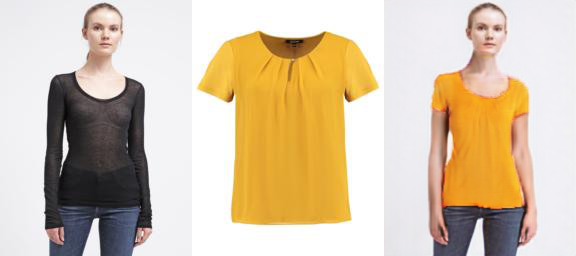

In [21]:
output_grid = np.concatenate([
    np.array(Image.open(f'Data_preprocessing/test_img/{img_name}')),
    np.array(Image.open(f'Data_preprocessing/test_color/{cloth_name}')),
    np.array(Image.open(f'results/test/try-on/{img_name}'))
], axis=1)

image_grid = Image.fromarray(output_grid)

image_grid

# FastAPI 코드 작성

자료가 부족해서 일단은 flask로 해보겠음

In [36]:
!pip install "fastapi[all]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
!pip install "fastapi[all]"
#!pip install colabcode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [37]:
from fastapi import FastAPI
from fastapi.responses import FileResponse
#from colabcode import ColabCode

In [ ]:
#cc = ColabCode(port = 8000, code = False)

In [38]:
app = FastAPI()

@app.get("/")
def home():
  return 'this is homepage'

@app.get("/get_image")
async def get_image():
  filename = "results/test/try-on/{img_name}.png"
  return FileResponse(filename)
  

In [ ]:
#cc.run_app(app=app)

In [35]:
#import nest_asyncio
#import uvicorn
#nest_asyncio.apply()

#if __name__ == "__main__":
#    uvicorn.run(app, host="0.0.0.0", port=8000)

INFO:     Started server process [871]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [871]


In [39]:
run_with_ngrok(app)
app.run()

NameError: ignored